In [1]:
from fastai.vision.all import *

from kornia import rgb_to_grayscale
class RGB2GreyTransform(DisplayedTransform):
    order = 15 # run after IntToFloatTransform
    def encodes(self, o:TensorImage):
         # expand restores tensor shape back to use c channels 
         # (ie. N,c,h,w) instead of N,1,h,w
         c = o.shape[1]
         return rgb_to_grayscale(o).expand(-1,c,-1,-1)
    
path = '/imagenet/ILSVRC2012'
dls = ImageDataLoaders.from_folder(path, valid='val', 
        item_tfms=RandomResizedCrop(128, min_scale=0.35),
        batch_tfms=[Normalize.from_stats(*imagenet_stats),RGB2GreyTransform])



def cornet_z_block(in_channels, out_channels, kernel_size=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                  stride=stride, padding=kernel_size // 2),
        nn.ReLU(inplace=True), # TODO: Find out what this does
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1), # Magic Numbers!
        Identity()
    )

cornet_z = nn.Sequential(
    cornet_z_block(3, 64, kernel_size=7, stride=2),
    cornet_z_block(64, 128),
    cornet_z_block(128, 256),
    cornet_z_block(256, 512),
    nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(512, 1000),
        Identity()
    )
)

loaded = Learner(dls, cornet_z, metrics=accuracy)
loaded.load('cornet_z_imagenet_greyscale')
loaded.summary()

/anaconda/envs/fastai2/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 64 x 64   
Conv2d                                    9472       True      
ReLU                                                           
MaxPool2d                                                      
Identity                                                       
____________________________________________________________________________
                     64 x 128 x 32 x 32  
Conv2d                                    73856      True      
ReLU                                                           
MaxPool2d                                                      
Identity                                                       
____________________________________________________________________________
                     64 x 256 x 16 x 16  
Conv2d                                    295168     True      
ReLU                                               

In [2]:
weights = loaded.model[0][0].weight.data.cpu()

weights[0][0]


tensor([[ 0.0004, -0.0411,  0.0155,  0.0052, -0.0343,  0.0373, -0.0052],
        [ 0.0154, -0.0972,  0.1482, -0.2172,  0.1172, -0.0431, -0.0321],
        [-0.0278, -0.0444,  0.0940, -0.2586,  0.2786, -0.1784,  0.0357],
        [-0.0441,  0.0423, -0.1153, -0.0339,  0.1162, -0.1828,  0.0352],
        [-0.0415, -0.0035, -0.1617,  0.1198, -0.0763, -0.0419,  0.0068],
        [-0.0139, -0.0085, -0.0390,  0.0837, -0.0717,  0.0572, -0.0170],
        [-0.0073, -0.0236, -0.0211,  0.0280, -0.0013,  0.0101,  0.0128]])

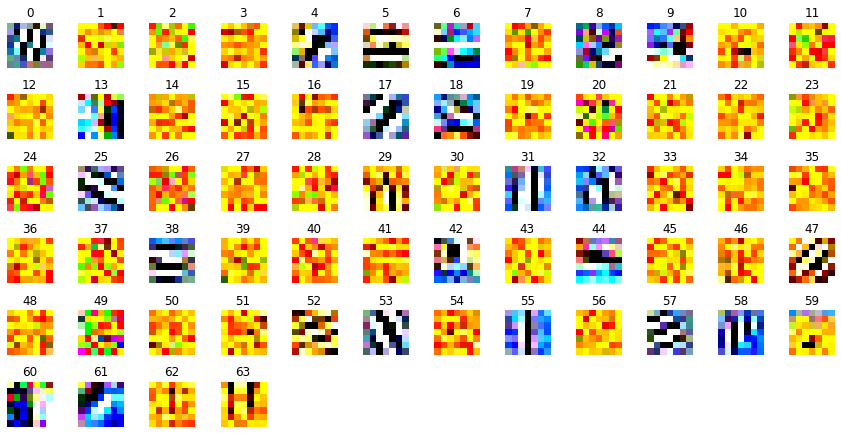

In [3]:
def plot_filters_multi_channel(t):
    
    #get the number of kernels
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()
    
plot_filters_multi_channel(weights)

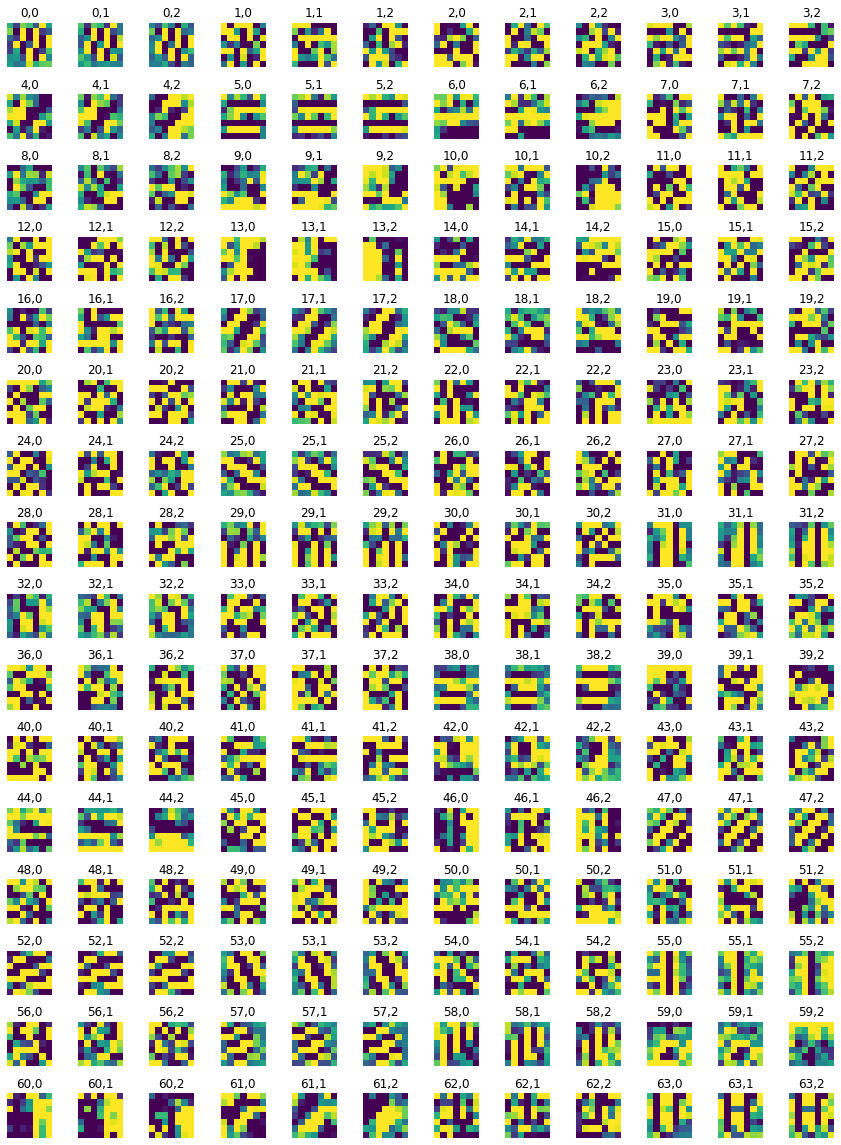

In [4]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()
    
plot_filters_single_channel(weights)

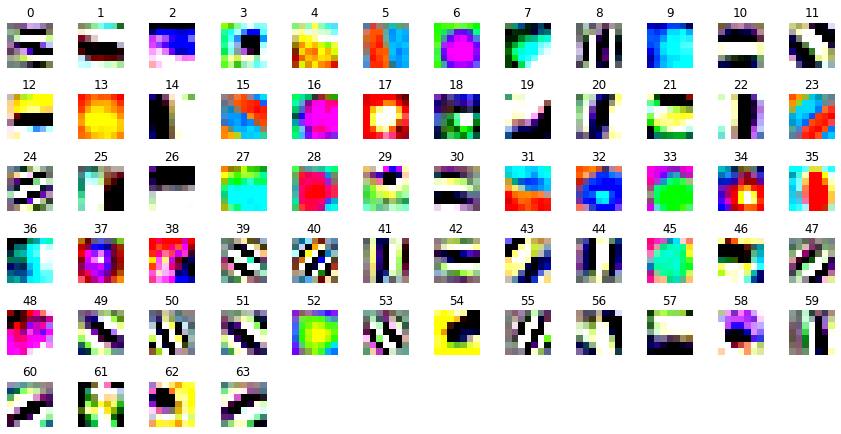

In [10]:
resnet18_model = resnet18(pretrained = True)
plot_filters_multi_channel(resnet18_model.conv1.weight.data)

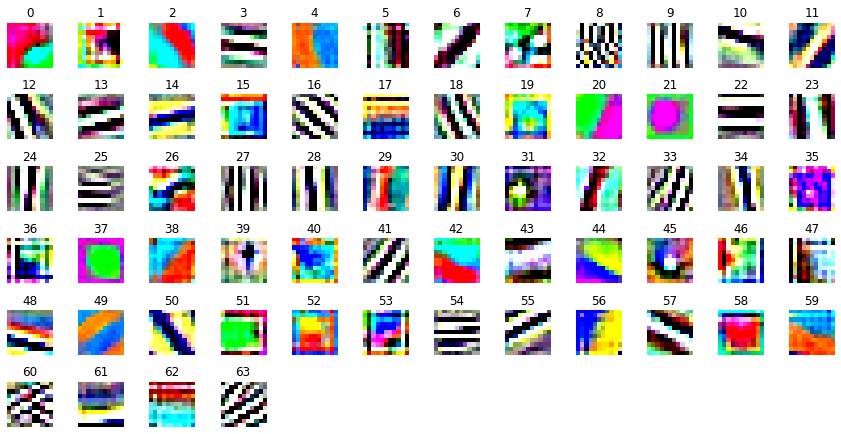

In [15]:
alexnet_model = alexnet(pretrained = True)
plot_filters_multi_channel(alexnet_model.features[0].weight.data)